# 1) Simulation Linear Standardization

Problems of slope and bias in the predictions when using a calibration model in a target instrument might be solved by slope and bias correction, but if their cause is a misaligment of wavelengths, linear standardization techniques are successful in these cases.

The current simulation is motivated in the cases in which the model provides aligned predictions with some degree of noise or dispersion

We test here DS, PDS, SST and Slope and Bias correction

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sp_io
from pycaltransfer import caltransfer


from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# --- my modules

import modules.utils_format as utils
from modules.sample_selection import sample_selection
import modules.functions as func


In [2]:
K = 1000 # number of wavelength channels
ncomp = 20
N = 600
y_comp = np.arange(10,15)
source_name = "Simulation"
target_name = "Pertubation"

# Simulation unsupervised

In [3]:
# loadings and mean

Pt,Pt_svd = func.genstruct(nstruct = ncomp, nvar = K, ngauss = 4, random_seed = 7654)
P_orth = Pt_svd.T[:,0:ncomp]

# loadings source and target domain


Psou = Pt.T[:,:]
x_mu = 50*func.genstruct(nstruct = 1, nvar = Psou.shape[0], ngauss = 40)[0]


# scores source domain

rng_scores = np.random.RandomState(4422455)
Tscores = rng_scores.multivariate_normal(mean = np.zeros(Psou.shape[1]), cov = np.diag(np.linspace(50,10,Psou.shape[1])), size=N)
Esou = rng_scores.multivariate_normal(mean = np.zeros(Psou.shape[0]), cov = 0.0000005*np.eye(Psou.shape[0]), size=N)
Xsou_clean = Tscores.dot(Psou.T) + Esou + x_mu



print("done")


done


# Simulation of Y values

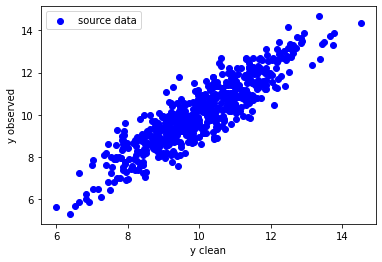

In [4]:
# simulation of Y values

u,d,Pt_clean = np.linalg.svd(Xsou_clean - x_mu)
Psou_final = Pt_clean.T.copy()


# scores

Tscores_sou = (Xsou_clean - x_mu).dot(Pt_clean.T[:,y_comp])
Xsou_all = (Xsou_clean - x_mu).dot(Psou_final.dot(Psou_final.T)) + Esou + x_mu

# parameters

Q = np.linspace(3,0.1,Tscores_sou.shape[1])
beta_sim = 10


# y values

rng_y = np.random.RandomState(8765)
Ysou_clean = beta_sim + Tscores_sou.dot(Q) 

Y_all = Ysou_clean + rng_y.normal(loc=0,scale = 0.7, size = Tscores_sou.shape[0])
Y_all.shape = (Y_all.shape[0], 1)

plt.scatter(Ysou_clean, Y_all, label = "source data", c = "blue")
plt.xlabel("y clean")
plt.ylabel("y observed")
plt.legend()
plt.show()


# Simulation of target instrument

Here we create the target instrument: An F diagonal matrix is created so it will cause each individual wavelength to be shrinked or expanded

Observe that this is an extreme case of linearity misalignment of the instruments


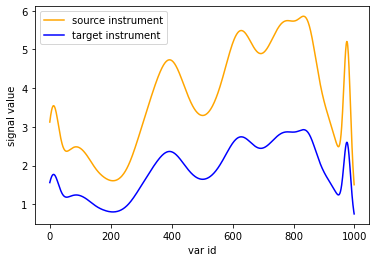

In [5]:

rng = np.random.RandomState(754357)
F_inv = 2*np.eye(K)
Etar = rng_scores.multivariate_normal(mean = np.zeros(K), cov = 0.0000005*np.eye(K), size=N)
Xtar_all = Xsou_all.dot(F_inv) + Etar


plt.plot(Xtar_all.mean(axis=0).T, c = "orange", label="source instrument")
plt.plot(Xsou_all.mean(axis=0).T, c = "blue", label = "target instrument")
plt.xlabel("var id")
plt.ylabel("signal value")
plt.legend()
plt.show()         



# Split into source and target data for cal and test

In [6]:

my_ss = sample_selection(Xsou_all, ncp = 10)
my_ss.get_xcal_pca_scores()
sou_samples = my_ss.kennard_stone(Nout = int(0.7*Xsou_all.shape[0]), use_pca_scores=True, distance_metric='mahalanobis') == 1

Xsou = Xsou_all[sou_samples,:]
Ysou = Y_all[sou_samples,:]
Xtar = Xtar_all[sou_samples,:]

Xsou_test = Xsou_all[sou_samples==False,:]
Xtar_test = Xtar_all[sou_samples==False,:]
Ytar_test = Y_all[sou_samples==False,:]



# Standard samples

In [7]:
rng = np.random.RandomState(754357)
stdsamples = rng.choice(Xsou.shape[0], 40, replace = False)

Xprimary = Xsou[stdsamples,:]
Xsecondary = Xtar[stdsamples,:]
Yprimary = Ysou[stdsamples,:]
Ysecondary = Ysou[stdsamples,:]
Xsou_cal = np.delete(Xsou, obj = stdsamples, axis = 0)
Ysou_cal = np.delete(Ysou, obj = stdsamples, axis = 0)

Xsou_cal.shape

(380, 1000)

In [8]:
print("calibration \n")
print("n " , Ysou_cal.shape[0]," \n",
      "mean ", Ysou_cal.mean()," \n",
    "std " , Ysou_cal.std())

print("standards \n")
print("n " , Xprimary.shape[0]," \n")


print("test \n")
print("n " , Ytar_test.shape[0]," \n",
      "mean ", Ytar_test.mean()," \n",
    "std " , Ytar_test.std())

calibration 

n  380  
 mean  10.132350721244658  
 std  1.6225443763575427
standards 

n  40  

test 

n  180  
 mean  10.020649505749162  
 std  1.4673498443838884


# PLS model building

In [9]:
xcal_pls = Xsou_cal.copy()
ycal_pls = Ysou_cal.copy()

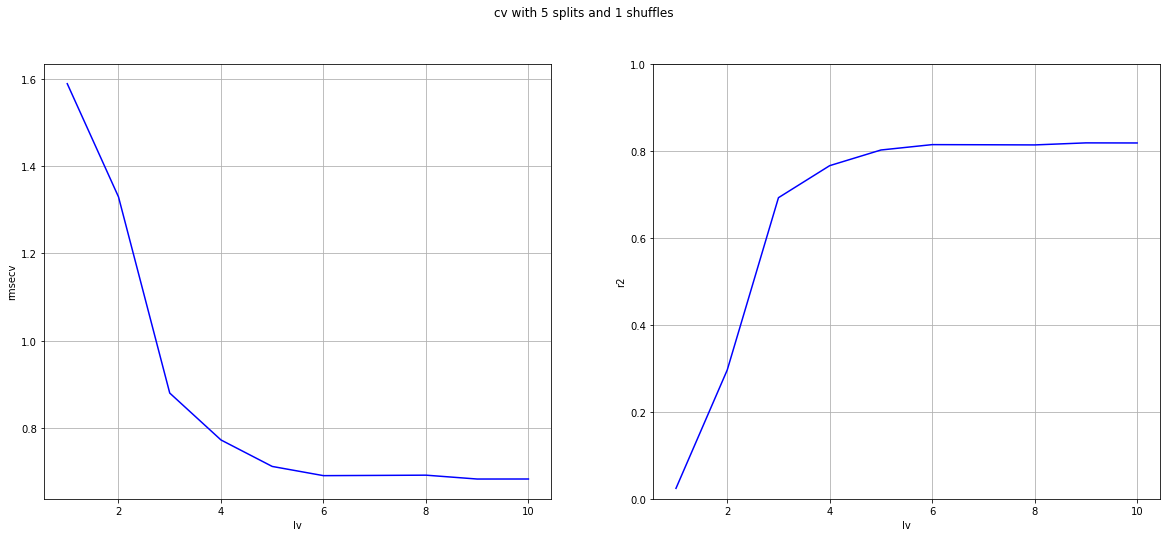

In [10]:
total_lv = 10
n_splits_cv = 5
n_shuffles = 1

parameters = {'n_components': list(range(1,total_lv+1))}
pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}


fig, axs = plt.subplots(1,2,figsize = (20,8))

for nn in range(n_shuffles):

    pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
    my_pls = PLSRegression(scale=False)
    my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
    my_pls_cv.fit(xcal_pls, ycal_pls)

    axs[0].plot(my_pls_cv.cv_results_["param_n_components"],-1*my_pls_cv.cv_results_["mean_test_rmse"], c = "blue")
    axs[1].plot(my_pls_cv.cv_results_["param_n_components"],my_pls_cv.cv_results_["mean_test_r2"], c = "blue")

axs[0].set_xlabel("lv")
axs[0].set_ylabel("rmsecv")
axs[0].grid()

axs[1].set_xlabel("lv")
axs[1].set_ylabel("r2")
axs[1].set_ylim([0,1])
axs[1].grid()


fig.suptitle("cv with {} splits and {} shuffles".format(n_splits_cv, n_shuffles))
plt.show()

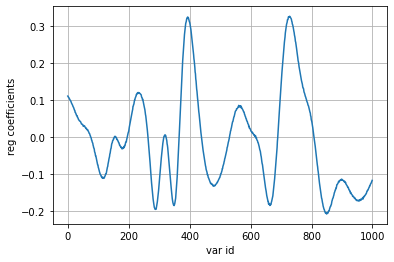

In [11]:
# choose model

chosen_lv = 5

my_pls = PLSRegression(n_components = chosen_lv,scale=False)
my_pls.fit(xcal_pls, ycal_pls)
x_mean = xcal_pls.mean(axis=0)
y_mean = ycal_pls.mean(axis=0)

# deliver model

B = my_pls.coef_
beta = y_mean - (x_mean.dot(B))

plt.plot(B)
plt.xlabel("var id")
plt.ylabel("reg coefficients")
plt.grid()
plt.show()

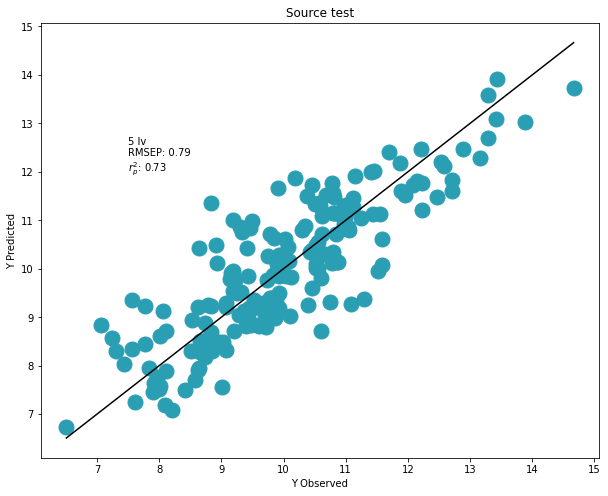

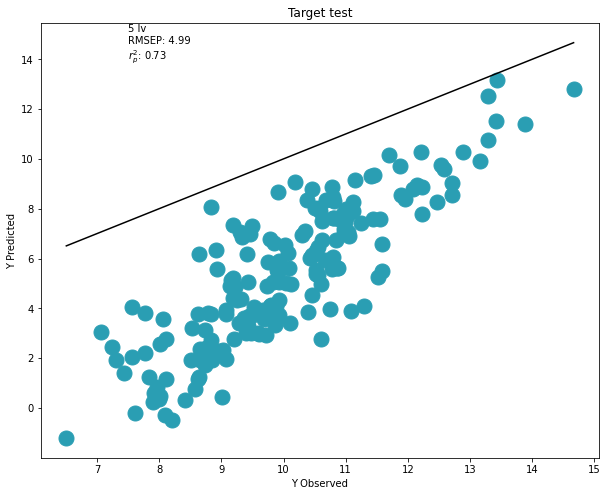

In [12]:
# use model in target domain

xsou_test = Xsou_test.copy()
xtar_test = Xtar_test.copy()
ytest_pls = Ytar_test.copy()


ytest_pls_pred = xsou_test.dot(B) + beta 


source_performance , (fig, ax_source) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Source test",
                                                    x_perf_t = 7.5,y_perf_t = 12, fig_width = 10,fig_height = 8)

# fig.savefig("../output/gasoline_modperf_sourceset.png")


ytest_pls_pred = xtar_test.dot(B) + beta 


target_performance , (fig, ax_target) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Target test",
                                                    x_perf_t = 7.5,y_perf_t = 14, fig_width = 10,fig_height = 8)
# fig.savefig("../output/gasoline_modperf_targetset.png")


# Standardization

In [13]:
F_ds,a_ds = caltransfer.ds_pc_transfer_fit(Xprimary, Xsecondary, max_ncp = Xsou.shape[1])
F_pds,a_pds = caltransfer.pds_pls_transfer_fit(Xprimary, Xsecondary, max_ncp = 1, ww = 1)
F_sst,a_sst = caltransfer.sst(Xprimary, Xsecondary, ncomp = 20)

In [14]:

Xtar_test_ds = Xtar_test.dot(F_ds) + a_ds
Xtar_test_pds = Xtar_test.dot(F_pds) + a_pds
Xtar_test_sst = Xtar_test.dot(F_sst) + a_sst


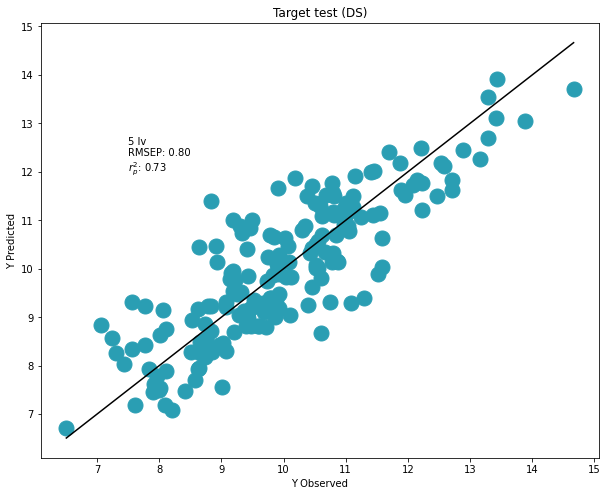

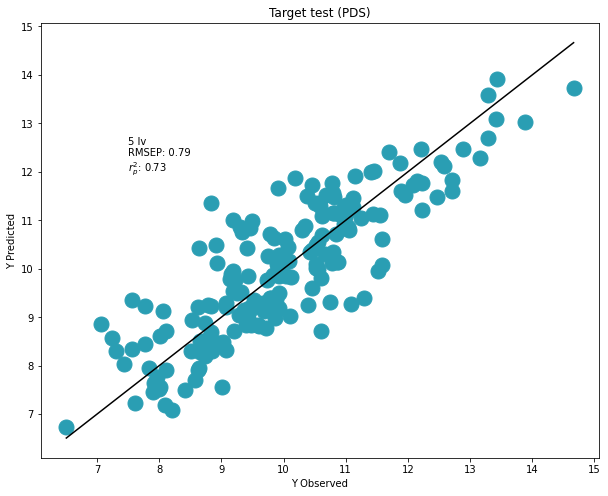

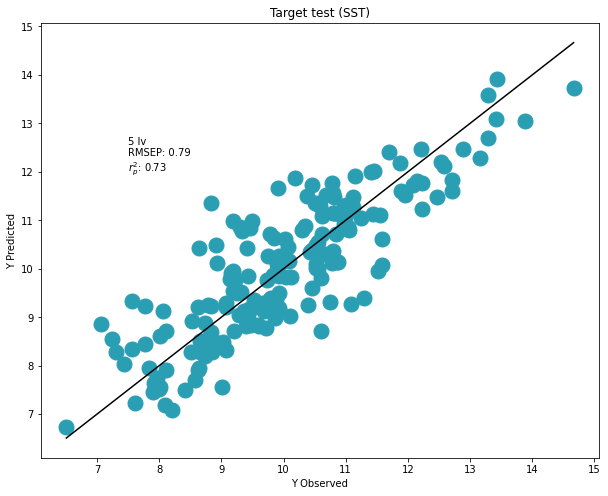

In [15]:
# use model in target domain after standardization



ytest_pls_pred = Xtar_test_ds.dot(B) + beta 


target_ds_performance , (fig, ax_ds) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Target test (DS)",
                                                    x_perf_t = 7.5,y_perf_t = 12, fig_width = 10,fig_height = 8)

# fig.savefig("../output/gasoline_modperf_targetds.png")


ytest_pls_pred = Xtar_test_pds.dot(B) + beta 


target_pds_performance , (fig, ax_pds) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Target test (PDS)",
                                                    x_perf_t = 7.5,y_perf_t = 12, fig_width = 10,fig_height = 8)

# fig.savefig("../output/gasoline_modperf_targetpds.png")


ytest_pls_pred = Xtar_test_sst.dot(B) + beta 


target_sst_performance , (fig, ax_sst) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Target test (SST)",
                                                    x_perf_t = 7.5,y_perf_t = 12, fig_width = 10,fig_height = 8)

# fig.savefig("../output/gasoline_modperf_targetsst.png")



# Slope and Bias correction

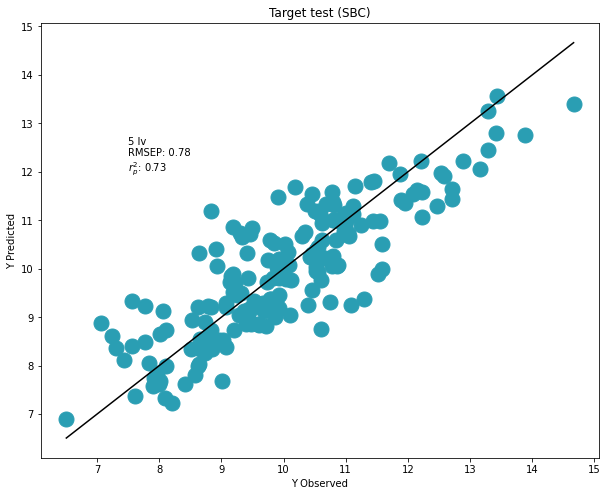

In [16]:
# SBC

xtar_test = Xtar_test.copy()
ytest_pls = Ytar_test.copy()


ytest_pls_pred_source = xtar_test.dot(B) + beta 
ysecondary_pls_pred_source = Xsecondary.dot(B) + beta 


slope, bias = caltransfer.slope_bias_correction(Yprimary, ysecondary_pls_pred_source)

ytest_pls_pred = ytest_pls_pred_source.dot(slope) + bias


target_sbc_performance , (fig, ax_sbc) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Target test (SBC)",
                                                    x_perf_t = 7.5,y_perf_t = 12, fig_width = 10,fig_height = 8)



